# Credit Default - Курсовой проект

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Путь к данным

In [2]:
TRAIN_DATASET_PATH = './Desktop/alistale/GB/kaggle/Credit/train.csv'
TEST_DATASET_PATH = './Desktop/alistale/GB/kaggle/Credit/test.csv'

#### Импорт библиотек

In [69]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import shapiro, probplot, mannwhitneyu
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### Функции

In [4]:
# Функция расчета эффективности модели
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def show_distplot(feature, data, title, figsize):
    """Диаграмма распределения признака со средней, медианой и модой"""
    
    target_mean = round(data[feature].mean(), 2)
    target_median = data[feature].median()
    target_mode = data[feature].mode()[0]

    plt.figure(figsize = figsize)

    sns.distplot(data[feature], bins=70)

    plt.axvline(x=[target_mean], label='target_mean', linestyle=':',linewidth=4, color='red')
    plt.axvline(x=[target_median], label='target_median', linestyle='--', linewidth=4, color='green')
    plt.axvline(x=[target_mode], label='target_mode', linestyle='-.', linewidth=4, color='orange')
    plt.title(title)
    plt.legend()

# Обзор обучающего датасета

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')

In [8]:
train_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Data fields

    Home Ownership - домовладение
    Annual Income - годовой доход
    Years in current job - количество лет на текущем месте работы
    Tax Liens - налоговые обременения
    Number of Open Accounts - количество открытых счетов
    Years of Credit History - количество лет кредитной истории
    Maximum Open Credit - наибольший открытый кредит
    Number of Credit Problems - количество проблем с кредитом
    Months since last delinquent - количество месяцев с последней просрочки платежа
    Bankruptcies - банкротства
    Purpose - цель кредита
    Term - срок кредита
    Current Loan Amount - текущая сумма кредита
    Current Credit Balance - текущий кредитный баланс
    Monthly Debt - ежемесячный долг
    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Пропуски в признаках:
Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score.

Категориальные признаки: 
Home Ownership, Years in current job, Purpose, Term

### Корреляция с базовыми признаками

Определим наиболее важные признаки для нашей целевой метки. Этим признакам мы уделим наиболее внимание при препроцессинге.

In [14]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop('Credit Default').tolist()

NUM_FEATURE_NAMES = [
 'Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

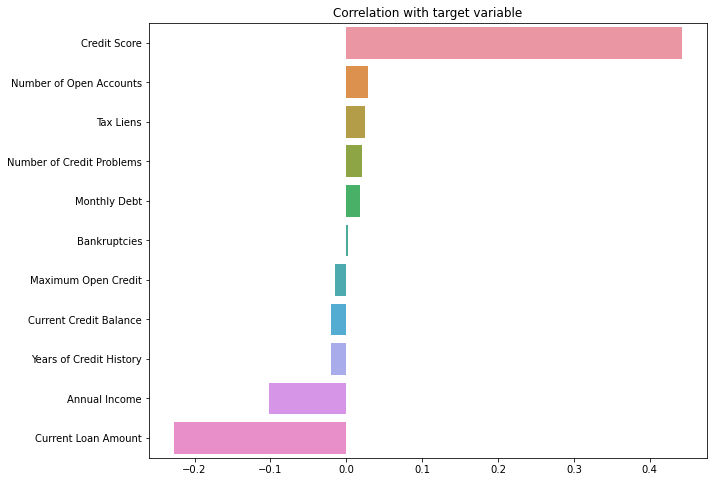

In [15]:
corr_with_target = train_df[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Наиболее важные признаки: Credit Score, Current Loan Amount, Annual Income, Number of open accounts.

Рассмотрим распределение целевой переменной

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


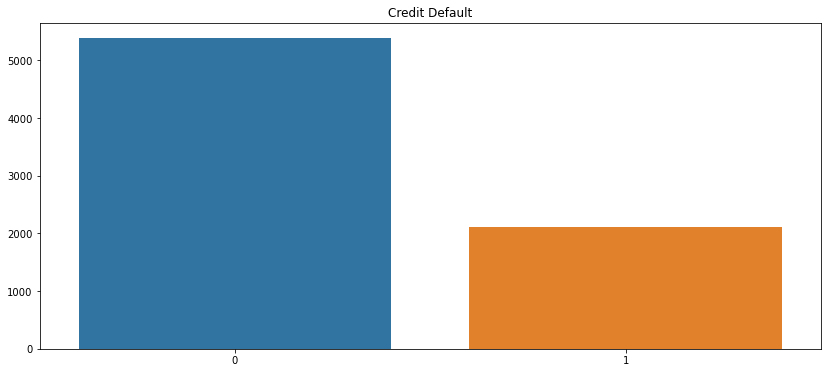

In [16]:
counts = train_df['Credit Default'].value_counts()
    
plt.figure(figsize=(14,6))    
plt.title('Credit Default')
sns.barplot(counts.index, counts.values)
    
plt.show()

Классы в датафрейме не сбалансированы: присутсвует преобладание нулевого класса. Данные необходимо балансировать

# Обработка выбросов

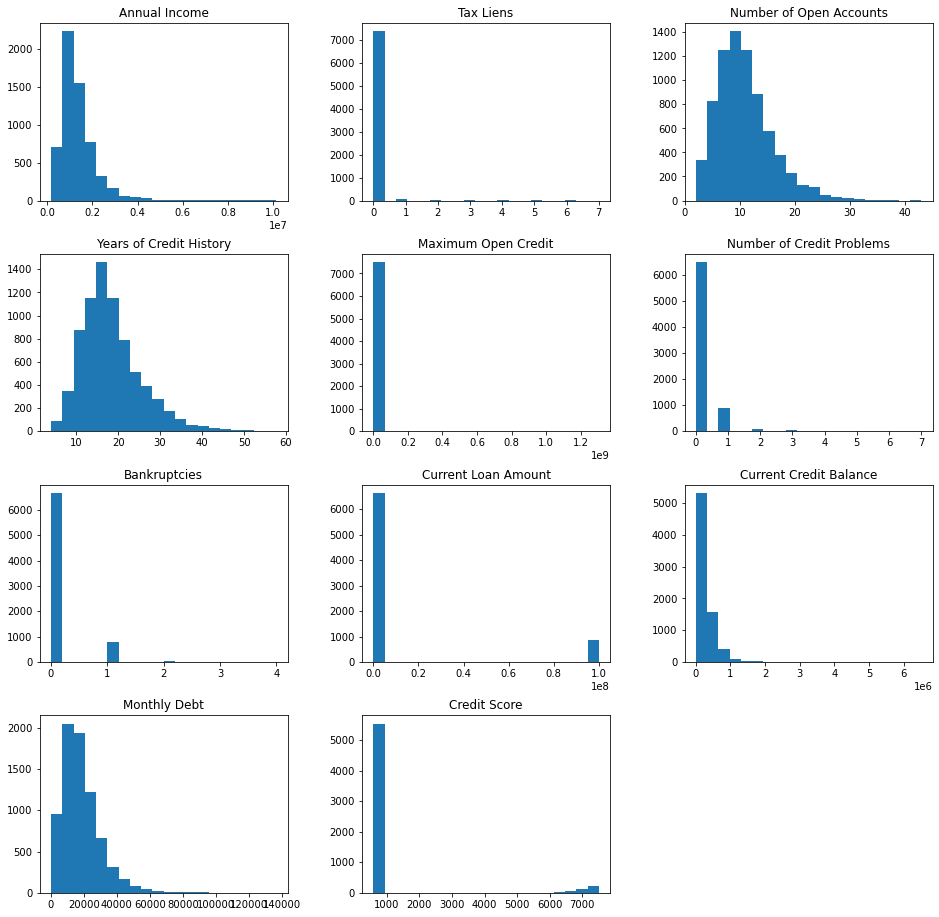

In [18]:
df_num_features = train_df[NUM_FEATURE_NAMES]
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

#### Current Loan Amount

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


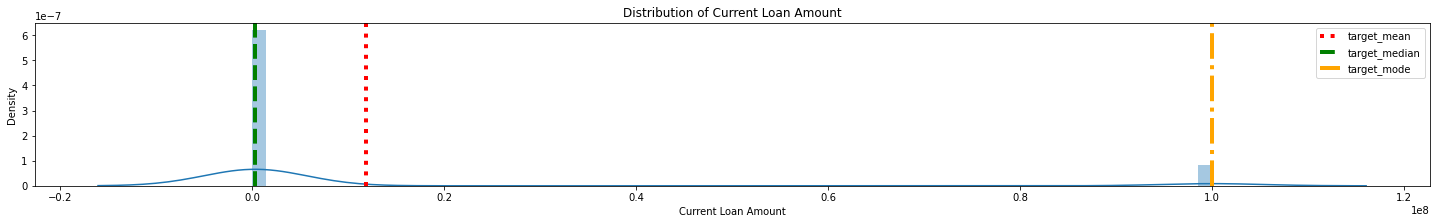

In [19]:
show_distplot(feature='Current Loan Amount', data=train_df, title='Distribution of Current Loan Amount', figsize=(25,3))

Распределение признака выглядит ненормальным. Значения выше квантиля 0.85 заменим на медиану.

In [20]:
train_df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [167]:
train_df['Current Loan Amount'].quantile(.85)

741790.5

# Обработка пропусков

In [23]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Current_Loan_Amount_fill           0
dtype: int64

In [24]:
# Уберем из датасета признак Months since last delinquent из-за большого кол-ва пропусков

In [25]:
train_df.drop('Months since last delinquent', axis=1, inplace=True)

In [26]:
# Заполним пустые значения в признаках Years in current job, Bankruptcies модой этого признака

In [27]:
train_df['Years in current job'] = train_df['Years in current job'].fillna('10+ years')

In [28]:
train_df['Bankruptcies'] = train_df['Bankruptcies'].fillna(0.0)

In [29]:
# Заменим пустые значения в признаках Credit Score, Annual Income медианой данных признаков

In [30]:
credit_score_median = train_df['Credit Score'].median()
annual_income_median = train_df['Annual Income'].median()

In [31]:
train_df['Credit Score'] = train_df['Credit Score'].fillna(credit_score_median)
train_df['Annual Income'] = train_df['Annual Income'].fillna(annual_income_median)

#### Итоговая функция предобработки данных

In [169]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.preprocessing import StandardScaler


class Data:

    def __init__(self):
        self.medians = None

    
    def fit(self, df):
        
        self.medians = df[['Annual Income', 'Credit Score', 'Current Loan Amount']].median()

    
    def transform_other_features(self, df):
        # преобразуем исходные данные
        
        df.drop('Months since last delinquent', axis=1, inplace=True)
        df['Years in current job'] = df['Years in current job'].fillna('10+ years')
        df['Bankruptcies'] = df['Bankruptcies'].fillna(0.0)
        df.drop('Tax Liens', axis=1, inplace=True)
        df.drop('Number of Credit Problems', axis=1, inplace=True)
        df.drop('Bankruptcies', axis=1, inplace=True)
        
     
        df['Credit_Score_fill'] = 0
        df.loc[df['Credit Score'].isna(), 'Credit_Score_fill'] = 1
        df['Credit Score'] = df['Credit Score'].fillna(self.medians['Credit Score'])
        df.drop('Credit_Score_fill', axis=1, inplace=True)
        
        df['Annual_Income_fill'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual_Income_fill'] = 1
        df['Annual Income'] = df['Annual Income'].fillna(self.medians['Annual Income'])
        df.drop('Annual_Income_fill', axis=1, inplace=True)
           
        
        df['Current_Loan_Amount_fill'] = 0
        df.loc[df['Current Loan Amount'] > 714790, 'Current_Loan_Amount_fill'] = 1
        df['Current Loan Amount'] = df['Current Loan Amount'].fillna(self.medians['Current Loan Amount'])
        df.drop('Current_Loan_Amount_fill', axis=1, inplace=True)
        
        return df
    

#### Инициализация класса

In [280]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
data_inst = Data()

data_inst.fit(train_df)

train_df = data_inst.transform_other_features(train_df)

# Анализ предобработанных данных

### Корреляция предобработанных данных с целевой переменной

In [281]:
NUM_FEATURE_NAMES = ['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

Text(0.5, 1.0, 'Correlation with target variable')

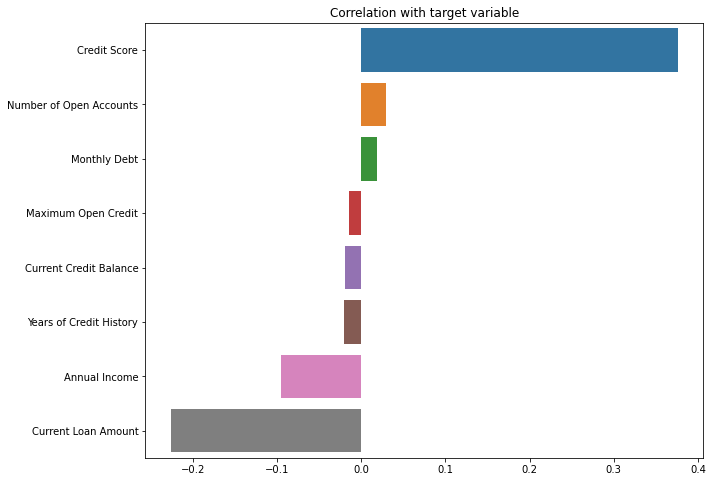

In [282]:
corr_with_target = train_df[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

### Корреляция признака Credit Score с целевой переменной в разрезе классов

Text(0.5, 1.0, 'Credit Score grouped by target variable')

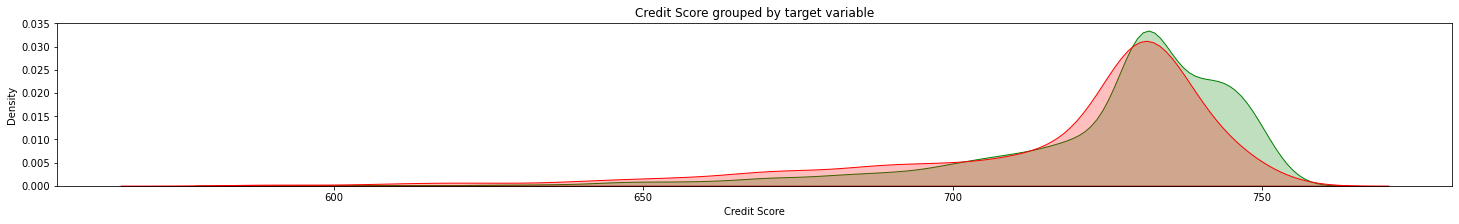

In [176]:
credit_score_with_target = train_df[train_df['Credit Score'] < 1000][['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(credit_score_target_0, shade=True, label='class 0', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='class 1', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')

In [177]:
shapiro(credit_score)

C:\Users\user\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.7988221645355225, pvalue=0.0)

Значение p-value меньше 0.05, следовательно распределение отлично от "нормального"

Text(0.5, 1.0, 'Confidence intervals (95 %) for Credit Score')

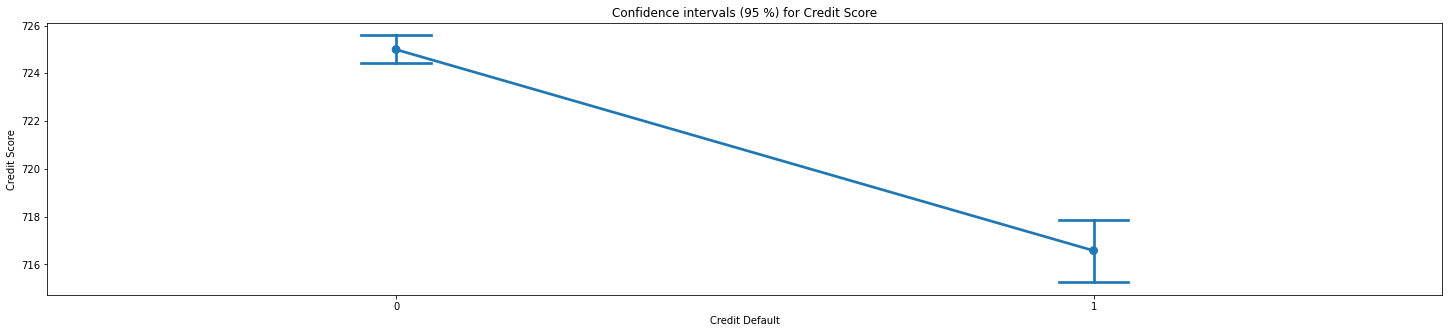

In [178]:
plt.figure(figsize=(25, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')

Математические ожидания не пересекаются. Признак будет полезен.

### Корреляция признака Annual Income с целевой переменной в разрезе классов

Text(0.5, 1.0, 'Annual Income grouped by target variable')

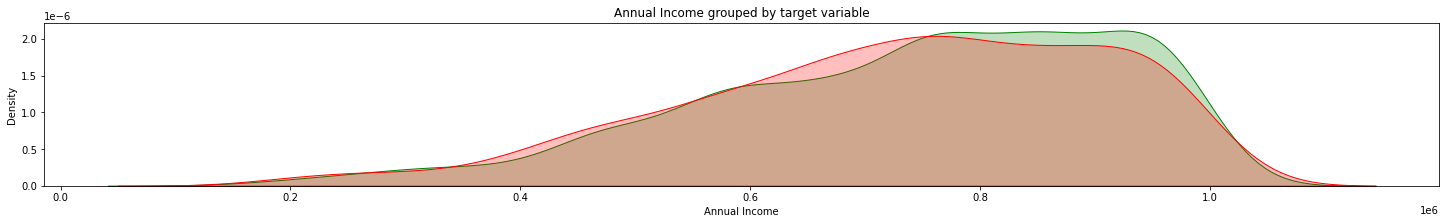

In [179]:
annual_income_with_target = train_df[train_df['Annual Income'] < 1000000][['Annual Income', TARGET_NAME]]
annual_income = annual_income_with_target['Annual Income']
annual_income_target_0 = annual_income[annual_income_with_target[TARGET_NAME] == 0]
annual_income_target_1 = annual_income[annual_income_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(annual_income_target_0, shade=True, label='class 0', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='class 1', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')

In [180]:
shapiro(annual_income)

ShapiroResult(statistic=0.9539735913276672, pvalue=5.937933527302231e-26)

Значение p-value , больше 0.05, следовательно распределение нормальное

Text(0.5, 1.0, 'Confidence intervals (95 %) for Annual Income')

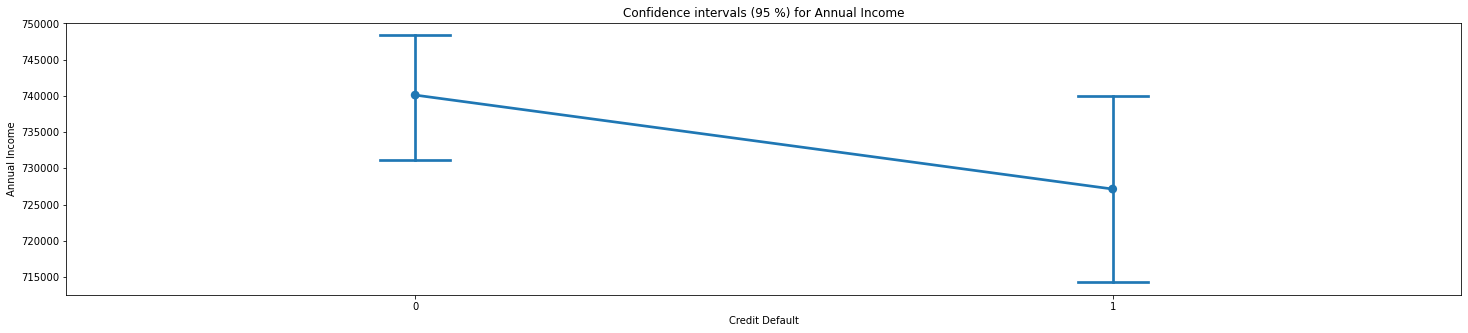

In [181]:
plt.figure(figsize=(25, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')

Математические ожидания пересекаются. Признак будет не самым полезным.

### Корреляция признака Current Loan Amount с целевой переменной в разрезе классов

Text(0.5, 1.0, 'Current Loan Amount grouped by target variable')

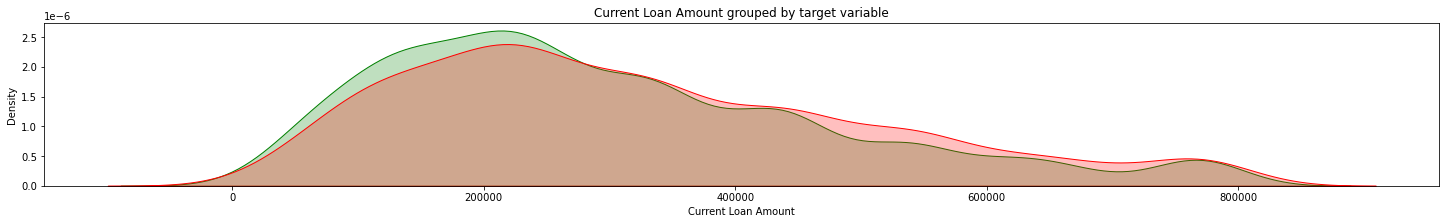

In [182]:
culoam_with_target = train_df[train_df['Current Loan Amount'] < 1000000][['Current Loan Amount', TARGET_NAME]]
culoam = culoam_with_target['Current Loan Amount']
culoam_target_0 = culoam[culoam_with_target[TARGET_NAME] == 0]
culoam_target_1 = culoam[culoam_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(culoam_target_0, shade=True, label='class 0', color='g')
sns.kdeplot(culoam_target_1, shade=True, label='class 1', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')

In [183]:
shapiro(culoam)

C:\Users\user\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9398760199546814, pvalue=1.401298464324817e-45)

Значение p-value , больше 0.05, следовательно распределение нормальное

Text(0.5, 1.0, 'Confidence intervals (95 %) for Current Loan Amount')

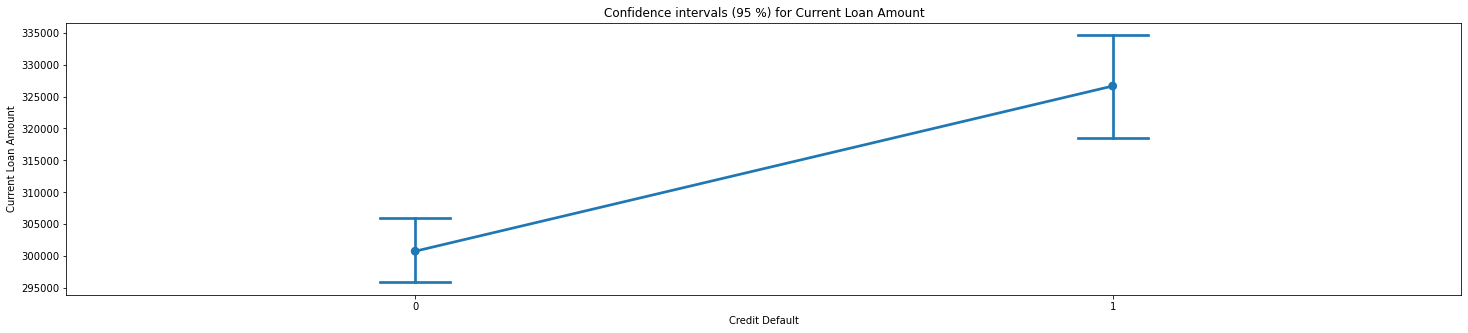

In [184]:
plt.figure(figsize=(25, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=culoam_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')

Математические ожидания не пересекаются. Признак будет полезен.

### Корреляция признака Number of open Accounts с целевой переменной в разрезе классов

Text(0.5, 1.0, 'Number of Open Accounts grouped by target variable')

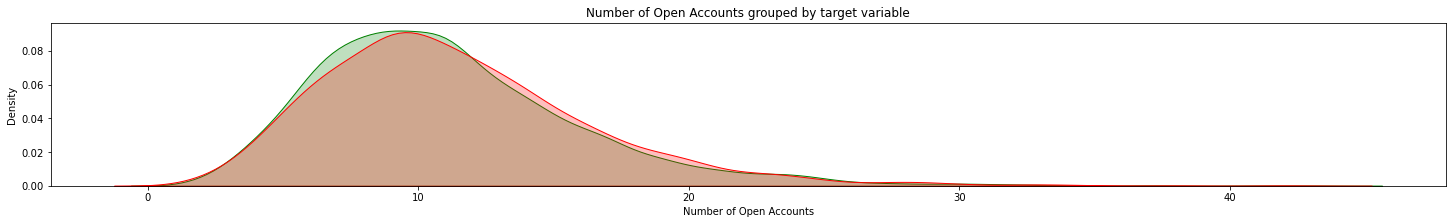

In [186]:
num_of_acc_with_target = train_df[train_df['Number of Open Accounts'] < 1000000][['Number of Open Accounts', TARGET_NAME]]
num_of_acc = num_of_acc_with_target['Number of Open Accounts']
num_of_acc_target_0 = num_of_acc[num_of_acc_with_target[TARGET_NAME] == 0]
num_of_acc_target_1 = num_of_acc[num_of_acc_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(num_of_acc_target_0, shade=True, label='class 0', color='g')
sns.kdeplot(num_of_acc_target_1, shade=True, label='class 1', color='r')

plt.xlabel('Number of Open Accounts')
plt.title('Number of Open Accounts grouped by target variable')

In [187]:
shapiro(num_of_acc)

C:\Users\user\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9372566342353821, pvalue=0.0)

Значение p-value меньше 0.05, следовательно распределение отлично от "нормального"

Text(0.5, 1.0, 'Confidence intervals (95 %) for Number of Open Accounts')

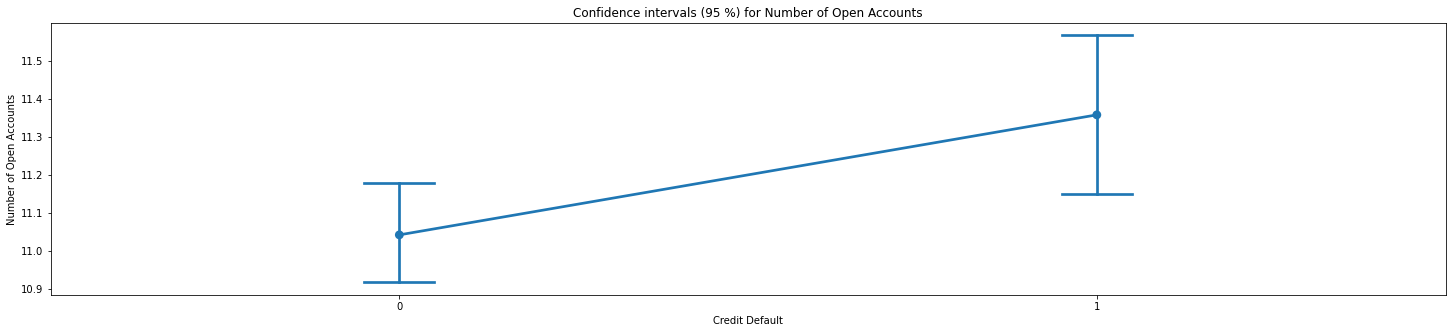

In [188]:
plt.figure(figsize=(25, 5))

sns.pointplot(x=TARGET_NAME, y='Number of Open Accounts', data=num_of_acc_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Number of Open Accounts')

Математические ожидания пересекаются. Признак будет не самым полезным.

# Отбор признаков

In [283]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [284]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop('Credit Default').tolist()

In [285]:
NUM_FEATURE_NAMES = [
 'Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

## Разбиение на train и test

In [286]:
X = train_df[NUM_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [287]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

## Балансировка классов

In [288]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [289]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [290]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

# Подбор моделей

#### Логистическая регрессия

In [291]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      3771
           1       0.63      0.51      0.57      2958

    accuracy                           0.66      6729
   macro avg       0.65      0.64      0.64      6729
weighted avg       0.65      0.66      0.65      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1616
           1       0.45      0.49      0.47       634

    accuracy                           0.69      2250
   macro avg       0.62      0.63      0.63      2250
weighted avg       0.70      0.69      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1237  379
1                321  313


#### K-ближайших соседей

In [292]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      3771
           1       0.74      0.71      0.72      2958

    accuracy                           0.76      6729
   macro avg       0.76      0.76      0.76      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1616
           1       0.36      0.45      0.40       634

    accuracy                           0.62      2250
   macro avg       0.56      0.57      0.56      2250
weighted avg       0.65      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1098  518
1                348  286


#### XGBoost

In [293]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3771
           1       0.97      0.95      0.96      2958

    accuracy                           0.97      6729
   macro avg       0.97      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.50      0.43      0.46       634

    accuracy                           0.72      2250
   macro avg       0.64      0.63      0.64      2250
weighted avg       0.71      0.72      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1345  271
1                363  271


#### LightGBM

In [294]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3771
           1       0.93      0.88      0.90      2958

    accuracy                           0.92      6729
   macro avg       0.92      0.91      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.51      0.44      0.47       634

    accuracy                           0.72      2250
   macro avg       0.65      0.64      0.64      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1349  267
1                358  276


#### CatBoost

##### Приведение типов для модели CatBoost

In [295]:
for colname in CAT_FEATURE_NAMES:
    train_df[colname] = pd.Categorical(train_df[colname])
    
train_df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [296]:
X_for_catb = train_df[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES]
y_for_catb = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X_for_catb, y_for_catb, shuffle=True, test_size=0.30, random_state=21)

In [297]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [298]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [299]:
params = {
    'eval_metric': 'F1',
    'silent': True,
    'cat_features': CAT_FEATURE_NAMES,
}

In [300]:
model_catb = catb.CatBoostClassifier(**params, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3771
           1       0.89      0.81      0.85      2958

    accuracy                           0.88      6729
   macro avg       0.88      0.87      0.87      6729
weighted avg       0.88      0.88      0.88      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1616
           1       0.55      0.51      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1353  263
1                311  323


CatBoost показал наилучшие результаты. Ее выбираем в качестве финальной модели.

# Настройка гиперпараметров

In [316]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=CAT_FEATURE_NAMES
)

params = {
    'eval_metric': 'F1',
    'silent': True,
    'cat_features': CAT_FEATURE_NAMES,
    'auto_class_weights': 'Balanced',
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

In [322]:
%%time

model_catb = CatBoostClassifier(**params)

params_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [30, 50, 100],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2]
}

gs = model_catb.randomized_search(
    params_grid,
    train_pool,
    n_iter=20,
    shuffle=True,
    stratified=True,
    partition_random_seed=42,
    cv=5
)

gs


bestTest = 0.6445346622
bestIteration = 49

0:	loss: 0.6445347	best: 0.6445347 (0)	total: 1.29s	remaining: 24.4s

bestTest = 0.6237092178
bestIteration = 29

1:	loss: 0.6237092	best: 0.6445347 (0)	total: 3.25s	remaining: 29.3s

bestTest = 0.6292669786
bestIteration = 29

2:	loss: 0.6292670	best: 0.6445347 (0)	total: 5.19s	remaining: 29.4s

bestTest = 0.7449598545
bestIteration = 29

3:	loss: 0.7449599	best: 0.7449599 (3)	total: 7.39s	remaining: 29.6s

bestTest = 0.7523263409
bestIteration = 49

4:	loss: 0.7523263	best: 0.7523263 (4)	total: 11.1s	remaining: 33.2s

bestTest = 0.7616649952
bestIteration = 96

5:	loss: 0.7616650	best: 0.7616650 (5)	total: 36.9s	remaining: 1m 26s

bestTest = 0.7000626891
bestIteration = 96

6:	loss: 0.7000627	best: 0.7616650 (5)	total: 38.1s	remaining: 1m 10s

bestTest = 0.7169438841
bestIteration = 49

7:	loss: 0.7169439	best: 0.7616650 (5)	total: 39.2s	remaining: 58.8s

bestTest = 0.7506773334
bestIteration = 99

8:	loss: 0.7506773	best: 0.7616650 (5)	to

{'params': {'bagging_temperature': 1,
  'depth': 10,
  'l2_leaf_reg': 3,
  'iterations': 100,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
        

Используем лучшие параметры для обучения финальной модели

# Обучение модели с настроенными гиперпараметрами

In [323]:
params_model = {
    'eval_metric': 'F1',
    'silent': True,
    'cat_features': CAT_FEATURE_NAMES,
    'auto_class_weights': 'Balanced',
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'bagging_temperature': 1,
    'depth': 10,
    'l2_leaf_reg': 3,
    'iterations': 100,
    'learning_rate': 0.1
}

In [324]:
%%time

model_catb = catb.CatBoostClassifier(
    **params_model,
    random_state=21
)

model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      3771
           1       0.72      0.75      0.74      2958

    accuracy                           0.76      6729
   macro avg       0.76      0.76      0.76      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1616
           1       0.48      0.63      0.54       634

    accuracy                           0.70      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1183  433
1                236  398
Wall time: 30.1 s


Модель сильно переобучена. Попробуем изменить рекомендованные параметры и снизить переобучение модели.

## Снижение степени переобучения

In [344]:
params_model_optimum = {
    'eval_metric': 'F1',
    'silent': True,
    'cat_features': CAT_FEATURE_NAMES,
    'auto_class_weights': 'Balanced',
    'one_hot_max_size': 30,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,

    'depth': 3,
    'iterations': 55,
    'bagging_temperature': 1.5,
    'learning_rate': 0.3,
    'l2_leaf_reg': 6
    
}

In [345]:
%%time

final_model = catb.CatBoostClassifier(
    **params_model_optimum,
    random_state=21
)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      3771
           1       0.67      0.71      0.69      2958

    accuracy                           0.72      6729
   macro avg       0.72      0.72      0.72      6729
weighted avg       0.72      0.72      0.72      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1616
           1       0.47      0.66      0.55       634

    accuracy                           0.69      2250
   macro avg       0.66      0.69      0.66      2250
weighted avg       0.74      0.69      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1142  474
1                213  421
Wall time: 545 ms


In [346]:
final_model.feature_importances_

array([ 6.79343861,  1.64120995,  1.08507108,  3.90699587, 29.32490688,
        1.6444309 ,  3.07955639, 44.07717646,  1.16531389,  0.        ,
        0.81565783,  6.46624213])

In [347]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [348]:
feature_importances.head(15)

,feature_name,importance
7,Credit Score,44.077176
4,Current Loan Amount,29.324907
0,Annual Income,6.793439
11,Term,6.466242
3,Maximum Open Credit,3.906996
6,Monthly Debt,3.079556
5,Current Credit Balance,1.644431
1,Number of Open Accounts,1.641210
8,Home Ownership,1.165314
2,Years of Credit History,1.085071


# Предсказание на валидационных данных

In [349]:
test_df = pd.read_csv(TEST_DATASET_PATH)


# Обработка тестовой выборки
data_inst.fit(test_df)

test_df = data_inst.transform_other_features(test_df)

In [350]:
submit = pd.read_csv('./Desktop/alistale/GB/kaggle/Credit/sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [351]:
X = test_df[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES]

In [352]:
for colname in CAT_FEATURE_NAMES:
    test_df[colname] = pd.Categorical(test_df[colname])
    
test_df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [353]:
predictions = final_model.predict(X)
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [354]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0


In [355]:
submit.to_csv('./Desktop/alistale/GB/kaggle/Credit/tsygantsova_submission.csv', index=False)